In [1]:
import hetmatpy.hetmat
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.metrics
import tqdm

In [2]:
hetmat = hetmatpy.hetmat.HetMat('hetionet-v1.0.hetmat/')

metapaths = hetmat.metagraph.extract_all_metapaths(1, True)
metaedges = [path[0] for path in metapaths]

In [4]:
[metaedge.abbrev for metaedge in metaedges]

['AlD',
 'AdG',
 'AeG',
 'AuG',
 'BPpG',
 'CCpG',
 'CrC',
 'CpD',
 'CtD',
 'CbG',
 'CdG',
 'CuG',
 'CiPC',
 'CcSE',
 'DrD',
 'DaG',
 'DdG',
 'DuG',
 'DpS',
 'GcG',
 'GiG',
 'G<rG',
 'GpMF',
 'GpPW']

In [8]:
metaedge = metaedges[0]

In [77]:
def mean_degree_variance(matrix):
    '''Compute the geometric mean of source and target degree variances'''
    return np.sqrt(np.var(matrix.sum(axis=0)) * np.var(matrix.sum(axis=1)))

def heterogeneity(G):
    '''
    Compute a topology-independent measure of degree heterogeneity
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5319345/
    '''
    hist = np.array(nx.degree_histogram(G))
    hist = hist / hist.sum()

    h = np.sqrt(((1 - hist[hist != 0])**2).sum() / len(hist))
    h_het = np.sqrt(1 - 3 / len(hist))
    h_m = h / h_het
    return h_m

In [125]:
records = list()
for metaedge in tqdm.tqdm_notebook(metaedges):
    source, target, mat = hetmat.metaedge_to_adjacency_matrix(metaedge, dtype=int, dense_threshold=1)
    G = nx.bipartite.from_biadjacency_matrix(mat)

    degree_sequence = np.array(list(dict(nx.degree(G)).values()))

    features = {
        'metaedge': metaedge.abbrev,
        'var': np.var(degree_sequence),
        'mean_var': mean_degree_variance(mat),
        'heterogeneity': heterogeneity(G),
    }
    records.append(features)

In [127]:
df = pd.DataFrame.from_records(records, columns=['metaedge', 'var', 'mean_var', 'heterogeneity'])
df.to_csv('hetionet_features.csv', index=False)
df.head()

,metaedge,var,mean_var,heterogeneity
0,AlD,178.424857,105.400995,0.666925
1,AdG,16213.712277,4746.423796,0.103437
2,AeG,213200.302894,63757.052580,0.113018
3,AuG,13951.699862,3429.167911,0.107764
4,BPpG,6274.709148,5430.031771,0.789888


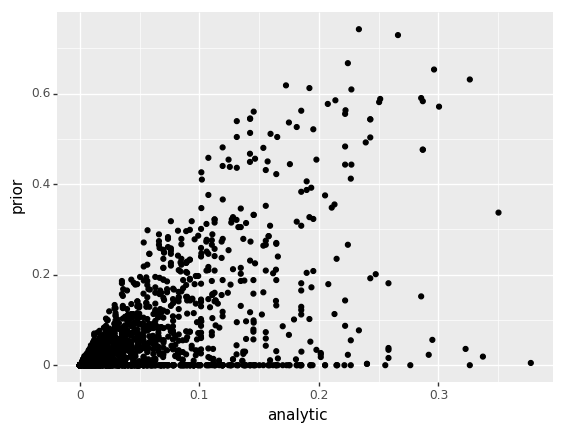

<ggplot: (8789012949708)>

In [166]:
import xswap

_, _ , mat = hetmat.metaedge_to_adjacency_matrix('DrD', dense_threshold=0, dtype=int)

def matrix_to_edges(matrix):
    edges = list()
    if np.array_equal(matrix, matrix.T):
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1] - i, matrix.shape[1]):
                if mat[i, j]:
                    edges.append((i, j))
    else:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if mat[i, j]:
                    edges.append((i, j))
    return edges

def edges_to_bipartite(edges, bipartite, shape):
    matrix = scipy.sparse.csc_matrix((np.ones(len(edges)), (zip(*edges))), shape=shape)
    if not bipartite:
        matrix = matrix + matrix.T - scipy.sparse.diags(mat.diagonal())
    return matrix

counter = np.zeros_like(mat)
perm_edges = matrix_to_edges(mat)
for i in range(1000):
    perm_edges, _ = xswap.permute_edge_list(perm_edges, allow_antiparallel=False, allow_self_loops=False, seed=i)
    perm_mat = edges_to_bipartite(perm_edges, False, mat.shape).toarray()
    counter = counter + perm_mat

counter /= 1000

df = (
    pd.DataFrame({
        'source_degree': np.outer(mat.sum(axis=1), np.ones(mat.shape[1])).flatten(),
        'target_degree': np.outer(np.ones(mat.shape[0]), mat.sum(axis=0)).flatten(),
        'edge': mat.flatten(), 
        'prior': counter.flatten(),
    })
    .assign(analytic=lambda df: df['source_degree'] * df['target_degree'] \
            / (df['source_degree'] * df['target_degree'] + df['edge'].sum() \
               - df['source_degree'] - df['target_degree'] + 1),
            product=lambda df: df['source_degree'] * df['target_degree'],
            k=lambda df: (df['source_degree'] + df['target_degree']) / df['product'],
    )
)

from plotnine import *

(
    ggplot(df.sample(frac=0.1), aes(x = 'analytic', y = 'prior'))
    + geom_point()
)

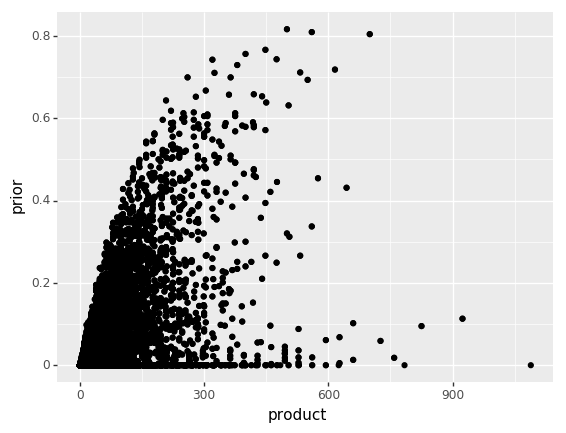

<ggplot: (-9223363247841200952)>

In [167]:
(
    ggplot(df, aes(x = 'product', y = 'prior'))
    + geom_point()
)

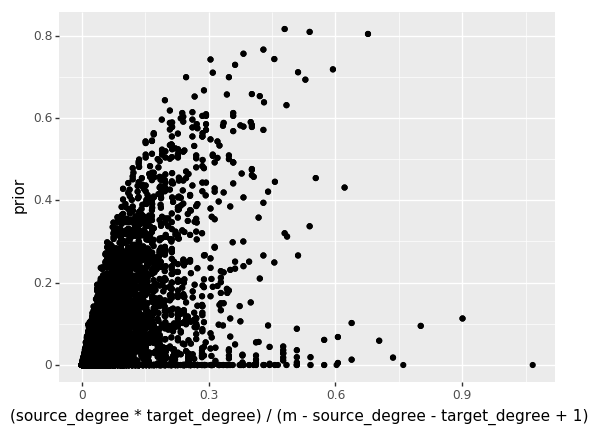

<ggplot: (-9223363247842970887)>

In [190]:
m = df['edge'].sum()

(
    ggplot(df, aes(x = '(source_degree * target_degree) / (m - source_degree - target_degree + 1)', y = 'prior'))
    + geom_point()
)

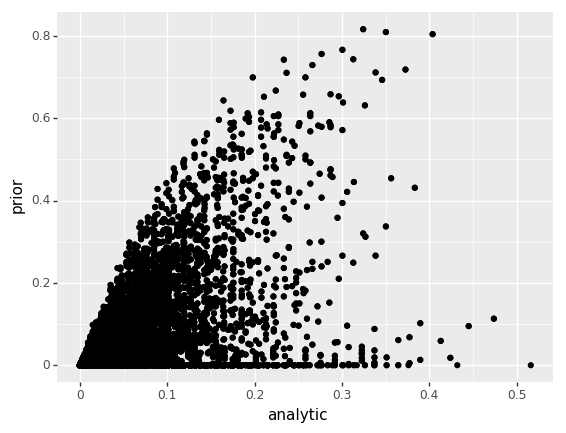

<ggplot: (-9223363247842757600)>

In [189]:
(
    ggplot(df, aes(x = 'analytic', y = 'prior'))
    + geom_point()
)

In [191]:
sklearn.metrics.roc_auc_score(df['edge'], df['analytic'])

0.8055626461889867